In [2]:
import os
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'
import h5py
import hdf5plugin  # REQUIRED to have the compression plugins available
import glob
import uvtools
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from pyuvdata import uvbeam, uvdata
from hera_filters import dspec
from hera_cal import io, frf, vis_clean, redcal, utils
from hera_cal.datacontainer import DataContainer, RedDataContainer
from IPython.display import display, HTML

%matplotlib inline
display(HTML("<style>.container { width:100% !important; }</style>"))
_ = np.seterr(all='ignore')  # get rid of red warnings
%config InlineBackend.figure_format = 'retina'

In [3]:
# Get file names
#SUM_FILE = os.environ.get("SUM_FILE", None)
#SUM_FILE = '/lustre/aoc/projects/hera/h6c-analysis/IDR2/2459866/zen.2459869.25282.sum.uvh5'
SUM_FILE = '/lustre/aoc/projects/hera/tsnyder/2459866_starlink/zen.2459869.66922.sum.uvh5'
RED_AVG_SUFFIX = os.environ.get("RED_AVG_SUFFIX", "sum.smooth_calibrated.red_avg.uvh5")

# Arguements for delay-filtering, fringe-rate filtering, cross-talk subtraction, and inpainting
XTALK_FR = float(os.environ.get("XTALK_FR", 0.025)) # Fringe rate half-width used for fringe rate filtering
FILT_MIN_DLY = float(os.environ.get("FILT_MIN_DLY", 150.)) # minimum delay for delay-filter in units of ns
INPAINT_MIN_DLY = float(os.environ.get("INPAINT_MIN_DLY", 500.)) # minimum delay for inpainting in units of ns
INPAINT_REGULARIZATION = float(os.environ.get("INPAINT_REGULARIZATION", 1e-5)) # reasonable values are between 1e-2 and 1e-5
STANDOFF = float(os.environ.get("STANDOFF", 50.)) # additional standoff added to min_dly for delay-filter in units of ns
INPAINT_FR = float(os.environ.get("INPAINT_FR", 2.5)) # Fringe-rate half-width in mHz for time inpainting
EIGENVAL_CUTOFF = float(os.environ.get("EIGENVAL_CUTOFF", 1e-12))

# Flag settings to get delay transform regions
FM_LOW_FREQ = float(os.environ.get("FM_LOW_FREQ", 87.5)) # in MHz
FM_HIGH_FREQ = float(os.environ.get("FM_HIGH_FREQ", 108.0)) # in MHz

# Maximum number of contiguous frequency channels in a time integration to attempt to inpaint over
# If number of contiguous flags is greater than this value, flagged channels will remain flagged
# and will attempt to be inpainted over along the time axis
MAX_CONTIGUOUS_FLAGS = int(os.environ.get("MAX_CONTIGUOUS_FLAGS", 20))

# Remove this number of channels on either side of the below/above FM bands to exclude from delay spectrum plots
SPECTRUM_CHAN_BUFFER = int(os.environ.get("SPECTRUM_CHAN_BUFFER", 25))

# Is the input LST-binned
IS_LST_BINNED = os.environ.get("IS_LST_BINNED", "FALSE").upper() == "TRUE"

for setting in ['XTALK_FR', 'FILT_MIN_DLY', 'INPAINT_MIN_DLY', 'STANDOFF', 'INPAINT_FR', 'EIGENVAL_CUTOFF', 
                'FM_LOW_FREQ', 'FM_HIGH_FREQ', 'MAX_CONTIGUOUS_FLAGS', 'SPECTRUM_CHAN_BUFFER', 'IS_LST_BINNED']:
        print(f'{setting} = {eval(setting)}')

XTALK_FR = 0.025
FILT_MIN_DLY = 150.0
INPAINT_MIN_DLY = 500.0
STANDOFF = 50.0
INPAINT_FR = 2.5
EIGENVAL_CUTOFF = 1e-12
FM_LOW_FREQ = 87.5
FM_HIGH_FREQ = 108.0
MAX_CONTIGUOUS_FLAGS = 20
SPECTRUM_CHAN_BUFFER = 25
IS_LST_BINNED = False


In [12]:
sum_glob = os.path.join(os.path.dirname(SUM_FILE), "*" + RED_AVG_SUFFIX)
red_avg_files = sorted(glob.glob(sum_glob))
red_avg_files = red_avg_files[0:42]
print(f'Found {len(red_avg_files)} *.{RED_AVG_SUFFIX} files starting with {red_avg_files[0]}.')

Found 42 *.sum.smooth_calibrated.red_avg.uvh5 files starting with /lustre/aoc/projects/hera/tsnyder/2459866_starlink/zen.2459866.66005.sum.smooth_calibrated.red_avg.uvh5.


In [13]:
# Select baselines for plotting
for i in range(len(red_avg_files) // 2):
    hd = io.HERADataFastReader(red_avg_files[(len(red_avg_files) // 2) + i])
    bls_to_plot = []

    # Find 1, 2, and 4 units EW auto-pol baselines 
    for bl in hd.bls:
        if utils.split_pol(bl[2])[0] == utils.split_pol(bl[2])[1]:
            bl_vec = (hd.antpos[bl[1]] - hd.antpos[bl[0]])
            if (np.abs(bl_vec[1]) < 1) and int(np.round(bl_vec[0] / 14.6)) in [1, 2, 4]:
                bls_to_plot.append(bl)

    # Get intersector baseline
    _, _, nsamples = hd.read()
    nsamples = RedDataContainer(nsamples, antpos=hd.antpos)
    # try a bunch of possible intersector baselines, hoping one will work
    for ant2 in range(226, 233):
        if (np.median(nsamples[(144, ant2, 'nn')]) > 0) & (np.median(nsamples[(144, ant2, 'ee')]) > 1):
            bls_to_plot.append(nsamples.get_ubl_key((144, ant2, 'nn')))
            bls_to_plot.append(nsamples.get_ubl_key((144, ant2, 'ee')))
            break
    if len(bls_to_plot) >= 8:
        break

# Identify indices
FM_LOW_FREQ_IND = np.argmin(np.abs(hd.freqs - FM_LOW_FREQ * 1e6))
FM_HIGH_FREQ_IND = np.argmin(np.abs(hd.freqs - FM_HIGH_FREQ * 1e6))

In [14]:
hd = io.HERADataFastReader(red_avg_files)
d, f, n = hd.read(pols=['nn', 'ee'], bls=bls_to_plot)

In [15]:
# Create a truncated version of the data to deal with edge times that are flagged
data = deepcopy(d)
flags = deepcopy(f)
nsamples = deepcopy(n)

# Identify unflagged edge channels
unflagged_chans = np.where(~np.all(flags[bls_to_plot[0]], axis=1))[0]
inds = np.arange(np.min(unflagged_chans), np.max(unflagged_chans) + 1)

# Fix data
for bl in data:
    data[bl] = d[bl][inds]
    flags[bl] = f[bl][inds]
    nsamples[bl] = n[bl][inds]
    
# Fix metadata
data.times = d.times[inds]
data.lsts = d.lsts[inds]

In [16]:
print(data.times)

[2459866.65999238 2459866.66010423 2459866.66021607 2459866.66032792
 2459866.66043977 2459866.66055162 2459866.66066347 2459866.66077532
 2459866.66088716 2459866.66099901 2459866.66111086 2459866.66122271
 2459866.66133456 2459866.6614464  2459866.66155825 2459866.6616701
 2459866.66178195 2459866.6618938  2459866.66200564 2459866.66211749
 2459866.66222934 2459866.66234119 2459866.66245304 2459866.66256488
 2459866.66267673 2459866.66278858 2459866.66290043 2459866.66301228
 2459866.66312412 2459866.66323597 2459866.66334782 2459866.66345967
 2459866.66357152 2459866.66368337 2459866.66379521 2459866.66390706
 2459866.66401891 2459866.66413076 2459866.66424261 2459866.66435445
 2459866.6644663  2459866.66457815 2459866.66469    2459866.66480185
 2459866.66491369 2459866.66502554 2459866.66513739 2459866.66524924
 2459866.66536109 2459866.66547294 2459866.66558478 2459866.66569663
 2459866.66580848 2459866.66592033 2459866.66603218 2459866.66614402
 2459866.66625587 2459866.66636772 

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


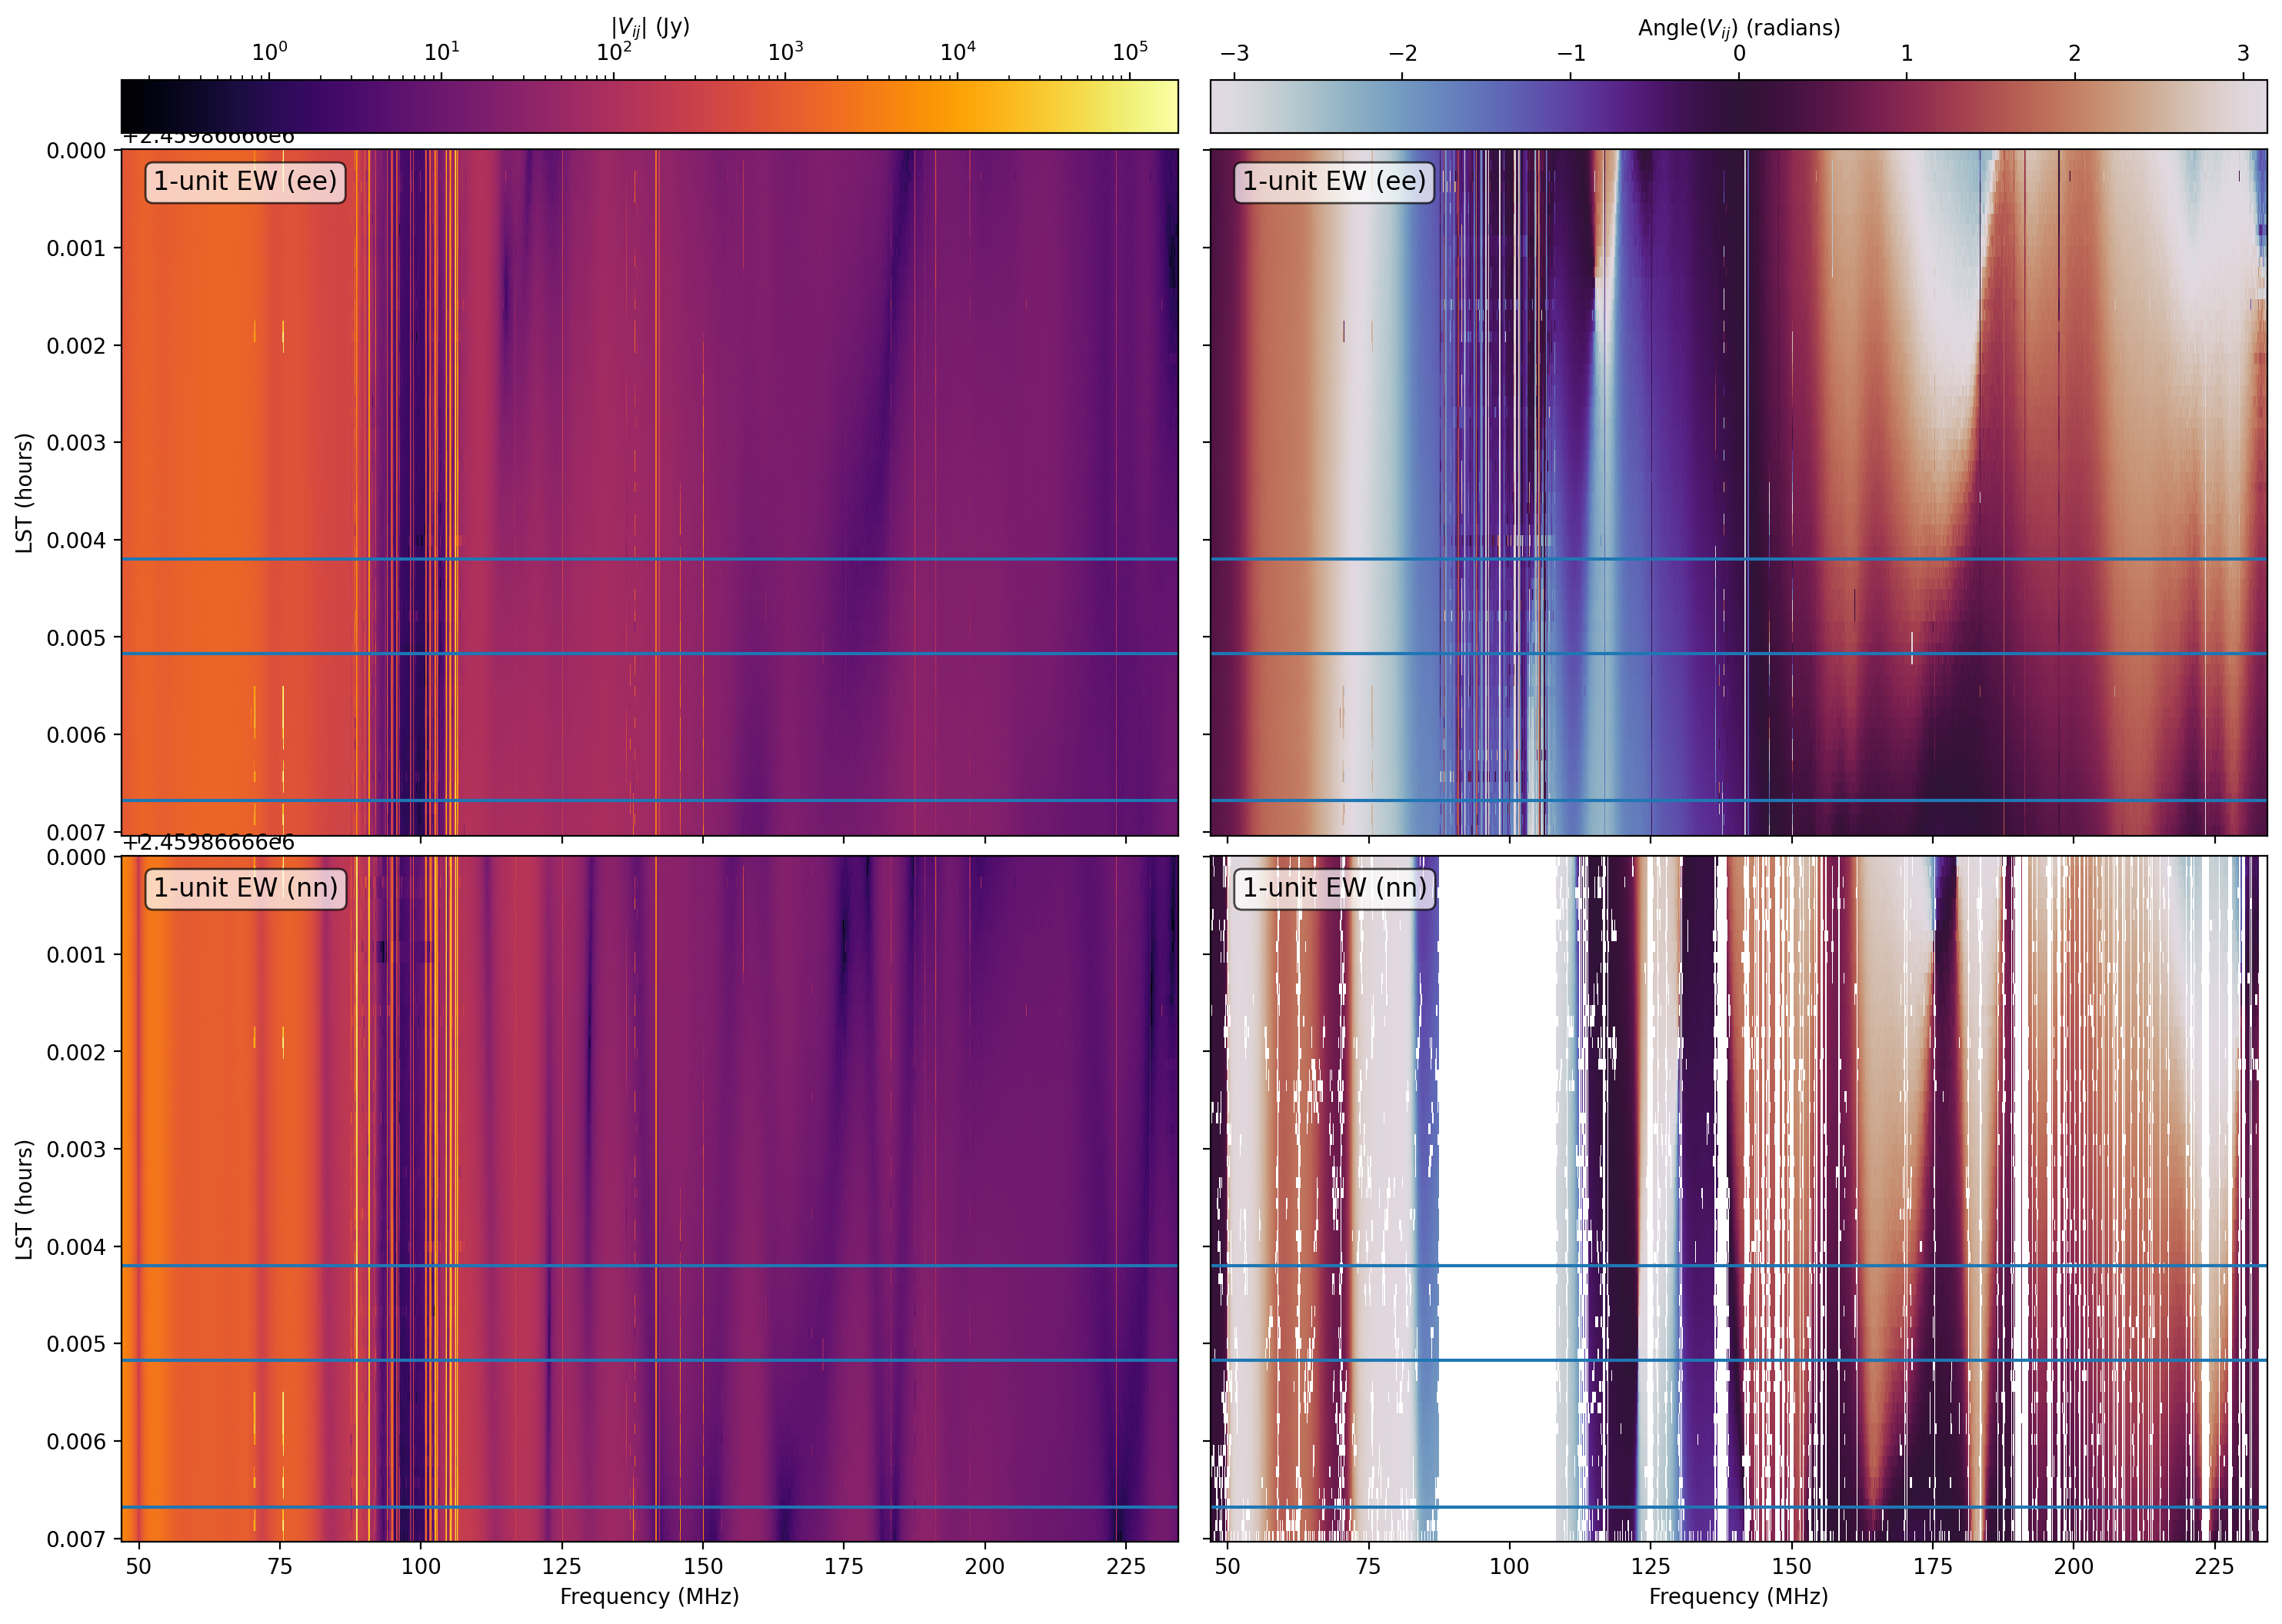

In [23]:
unit = int(np.round(np.linalg.norm(data.antpos[bls_to_plot[0][1]] - data.antpos[bls_to_plot[0][0]]) / 14.6, 1))
display(HTML(f'<h2>Figure 1: Amplitude and Phase of Calibrated {unit}-unit EW Redundantly-Averaged Baseline</h2>'))

# Get the LSTs from the data
lsts_unwrapped = np.where(data.lsts > data.lsts[-1], data.lsts - 2 * np.pi, data.lsts) * 12 / np.pi  # in hours
extent = [data.freqs[0] / 1e6, data.freqs[-1] / 1e6, data.times[-1], data.times[0]]

if not IS_LST_BINNED:
    fig, axs = plt.subplots(2, 2, figsize=(18, 14), sharex=True, sharey=True, gridspec_kw={'hspace': .03, 'wspace': .03})
else:
    fig, axs = plt.subplots(2, 3, figsize=(18, 14), sharex=True, sharey=True, gridspec_kw={'hspace': .03, 'wspace': .03})
    
fig.subplots_adjust(hspace=0.1, wspace=0.1)

# Plot the amplitude of ee and nn
# im1 = axs[0, 0].imshow(np.where(flags[bls_to_plot[0]], np.nan, np.abs(data[bls_to_plot[0]])), aspect='auto', interpolation='none',
#                    norm=matplotlib.colors.LogNorm(), cmap='inferno', extent=extent)
im1 = axs[0, 0].imshow(np.abs(data[bls_to_plot[0]]), aspect='auto', interpolation='none',
                   norm=matplotlib.colors.LogNorm(), cmap='inferno', extent=extent)
#axs[1, 0].imshow(np.where(flags[bls_to_plot[1]], np.nan, np.abs(data[bls_to_plot[1]])), aspect='auto', interpolation='none',
                   #norm=matplotlib.colors.LogNorm(vmin=im1.get_clim()[0], vmax=im1.get_clim()[1]), cmap='inferno', extent=extent)
axs[1, 0].imshow(np.abs(data[bls_to_plot[1]]), aspect='auto', interpolation='none',
                   norm=matplotlib.colors.LogNorm(), cmap='inferno', extent=extent)

# Plot the phase of ee and nn
# im2 = axs[0, 1].imshow(
#     np.where(flags[bls_to_plot[0]], np.nan, np.angle(data[bls_to_plot[0]])), 
#     aspect='auto', cmap='twilight', interpolation='None', extent=extent,
#     vmin=-np.pi, vmax=np.pi
# )
im2 = axs[0, 1].imshow(
    np.angle(data[bls_to_plot[0]]), 
    aspect='auto', cmap='twilight', interpolation='None', extent=extent,
    vmin=-np.pi, vmax=np.pi
)
axs[1, 1].imshow(
    np.where(flags[bls_to_plot[1]], np.nan, np.angle(data[bls_to_plot[1]])), 
    aspect='auto', cmap='twilight', interpolation='None', extent=extent,
    vmin=-np.pi, vmax=np.pi
)

fig.colorbar(im1, ax=axs[:, 0], label='$|V_{ij}|$ (Jy)', location='top', pad=0.01)
fig.colorbar(im2, ax=axs[:, 1], label='Angle($V_{ij})$ (radians)', location='top', pad=0.01)

if IS_LST_BINNED:
    # Plot the amplitude of ee and nn
    im3 = axs[0, 2].imshow(np.where(flags[bls_to_plot[0]], np.nan, nsamples[bls_to_plot[0]]), aspect='auto', interpolation='none',
                       cmap='viridis', extent=extent)
    axs[1, 2].imshow(np.where(flags[bls_to_plot[1]], np.nan, nsamples[bls_to_plot[1]]), aspect='auto', interpolation='none',
                       vmin=im3.get_clim()[0], vmax=im3.get_clim()[1], cmap='viridis', extent=extent)
    fig.colorbar(im3, ax=axs[:, 2], label='Number of Samples', location='top', pad=0.01)
    
    bls_for_labeling = [bls_to_plot[0][2]] * 3 + [bls_to_plot[1][2]] * 3
else:
    bls_for_labeling = [bls_to_plot[0][2]] * 2 + [bls_to_plot[1][2]] * 2

for ax, pol in zip(axs.ravel(), bls_for_labeling):
    ax.text(0.03, 0.97, f"{unit}-unit EW ({pol})", 
             horizontalalignment='left', verticalalignment='top', 
             color='black', transform=ax.transAxes, fontsize=12, 
             bbox=dict(facecolor='w', alpha=.7, boxstyle='round'))
    
    ax.hlines([2459866.665173611, 2459866.6666782405, 2459866.664201389] , extent[0], extent[1])
    
for i in range(axs.shape[1]):
    axs[1, i].set_xlabel('Frequency (MHz)')

for i in range(axs.shape[0]):
    axs[i, 0].set_ylabel('LST (hours)')

plt.tight_layout()

In [19]:
print(extent)

[np.float64(46.9207763671875), np.float64(234.2987060546875), np.float64(2459866.667038809), np.float64(2459866.659992378)]


In [8]:
import numpy as np
#import matplotlib.pyplot as plt
from pyuvdata import UVData
import pyuvdata
import astropy
import docstring_parser
import h5py
#import numba
import scipy

In [9]:
sample_file='zen.2459866.66900.sum.smooth_calibrated.red_avg.uvh5'
uvdata = UVData()  
uvdata.read(sample_file)

In [10]:
n_ants = uvdata.Nants_data  
n_ants_tot = uvdata.Nants_telescope  
data_ant = set(uvdata.ant_1_array).union(uvdata.ant_2_array) 

print(f"There are {n_ants} antennas with data") #, and they are:\n{data_ant}\n")

freq_MHz = np.unique(uvdata.freq_array) / 1e6
fmin = freq_MHz.min()
fmax = freq_MHz.max()
print(f"There are {uvdata.Nfreqs} frequencies, covering {fmin:.2f} MHz to {fmax:.2f} MHz.\n")
print(f"There are {uvdata.Ntimes} integrations.")

There are 172 antennas with data
There are 1536 frequencies, covering 46.92 MHz to 234.30 MHz.

There are 2 integrations.


In [11]:
freq_w = uvdata.channel_width
print("Channel Width is", freq_w[0],"Hz")
print("")    

Jul_d = uvdata.time_array
JD_min = Jul_d.min()
JD_max = Jul_d.max()
print(f"The range of Julian Dates spans from {JD_min:.6f} to {JD_max:.6f}")
print(f"The difference of this range is {(JD_max-JD_min):.8f}")
print("")

int_s = uvdata.integration_time
print(f"Length of integration is {int_s[0]:.3f} seconds")
print("")

times, inds = np.unique(uvdata.time_array, return_index=True)
lsts = uvdata.lst_array[inds]
lst_hr = lsts*12/np.pi
Lst_min = lst_hr.min()
Lst_max = lst_hr.max()
print(f"The range of LSTs spans from {Lst_min:.4f} hours to {Lst_max:.4f} hours")
print(f"The difference of this range is {(Lst_max-Lst_min):.4f} hours")
print("")

b_line = uvdata.baseline_array
print("the baseline numbers are", b_line[0:3])

Channel Width is 122070.3125 Hz

The range of Julian Dates spans from 2459866.668940 to 2459866.669052
The difference of this range is 0.00011185

Length of integration is 9.664 seconds

The range of LSTs spans from 6.9957 hours to 6.9984 hours
The difference of this range is 0.0027 hours

the baseline numbers are [374865 374865 374882]


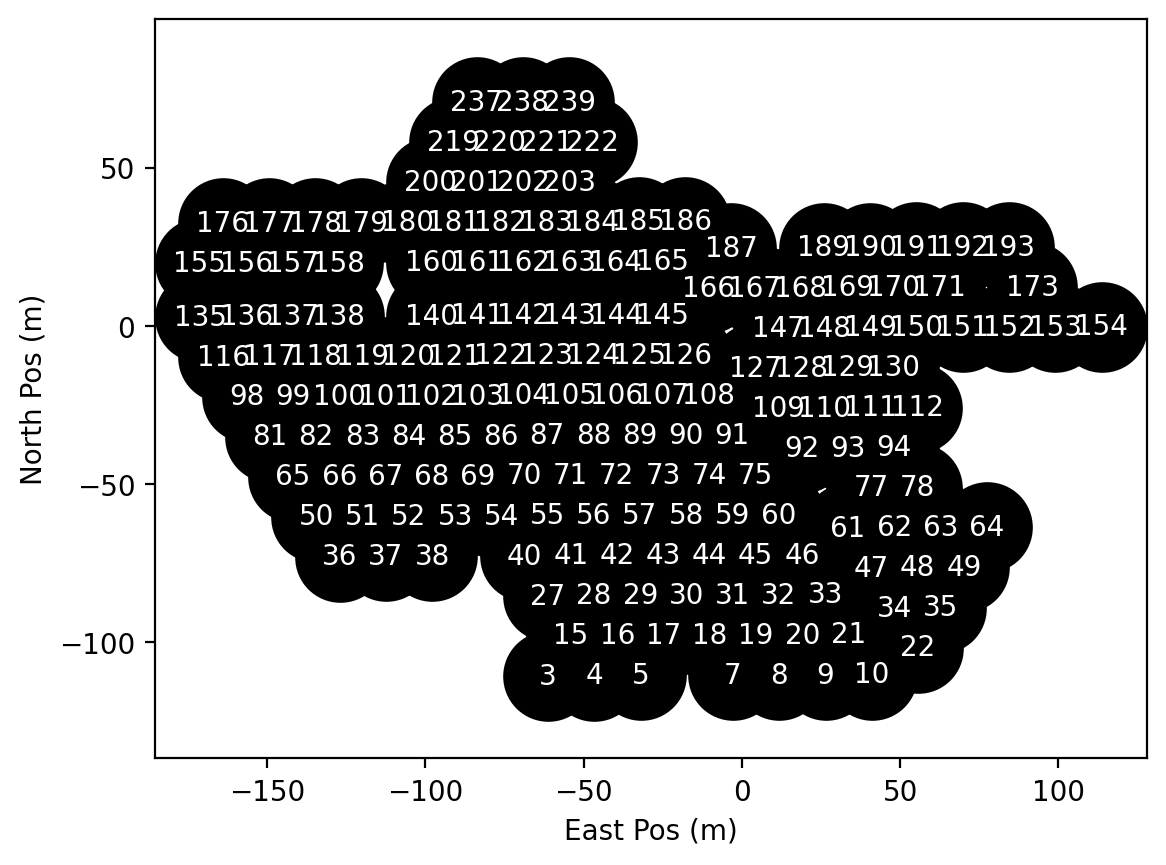

In [12]:
antspos = uvdata.get_enu_data_ants()[0]
antsnum = uvdata.get_enu_data_ants()[1]

antpos_x = antspos[:,0]
antpos_y = antspos[:,1]
antpos_z = antspos[:,2]

plt.figure()
plt.scatter(antpos_x, antpos_y, marker='.', color='k', s=4000)
for i, ant in enumerate(antsnum): 
    plt.text(antpos_x[i], antpos_y[i], ant, color='w', va='center', ha='center')
plt.xlabel('East Pos (m)')
plt.ylabel('North Pos (m)')
plt.axis('equal');

In [23]:
#print(uvdata.get_antpairpols())

In [13]:
antpp = (151, 3, 'nn')
data = uvdata.get_data(antpp)
flags = uvdata.get_flags(antpp)

In [14]:
# flags will be used on data a lot, so a function was made to make this easier.
def apply_flags(data, flags):
    return np.where(flags, np.nan+1j*np.nan, data)

In [15]:
data_mod = apply_flags(data, flags)

In [16]:
# Let's use a logarithmic colormap for visualizing the visibility amplitude
vmin = np.abs(data[~flags]).min()  # Get the smallest non-flagged visibility amplitude
vmax = np.abs(data[~flags]).max()  # and the largest
norm = plt.cm.colors.LogNorm(vmin=vmin, vmax=vmax)  # This will tell the plotter how to format the colorbar

# The extent of a plot is [left, right, bottom, top]
# Remember that imshow has the vertical axis increasing downward!
extent = [freq_MHz[0], freq_MHz[-1], lst_hr[-1], lst_hr[0]]

# Plot absolute value of visibility
plt.figure(figsize=(8,4))
plt.subplot(121)  # Use 1 row and 2 columns of plots; select the left plot
plt.imshow(np.abs(data), aspect='auto', norm=norm, interpolation='none', extent=extent)
plt.colorbar(label='Visibility Amplitude (Jy)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Amplitude')

# Plot phase of visibility
plt.subplot(122)  # Now select the right plot
plt.imshow(np.angle(data), aspect='auto', cmap='twilight', interpolation='none', extent=extent)
plt.colorbar(label='Visibility Phase (Radians)')
plt.xlabel('Frequency (MHz)')
plt.ylabel('LST (hours)')
plt.title('Phase')

plt.tight_layout();

ValueError: zero-size array to reduction operation minimum which has no identity